In [897]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from formulas import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
 
import tensorflow as tf

keras = tf.keras

In [898]:
write_complete_dataframe_path = Path("__file__").parent.joinpath("Manipulated_Data", "Merged_Data").parent.joinpath("Merged_Data", "Merged-Data.csv")
df= pd.read_csv(write_complete_dataframe_path, index_col=0)
df = df[["Date", "Carbon Price"]]
df["Date"] = pd. to_datetime(df["Date"])
df.head()

,Date,Carbon Price
0,2012-11-09,8.20
1,2012-11-13,8.49
2,2012-11-16,6.75
3,2012-11-20,6.47
4,2012-11-23,6.75


In [899]:
df = df[df.Date >="2019-01-01"]
df = df[df.Date <="2022-12-31"]
#df = df[df["Date"] >= "2012-01-01"]
#df = df[df["Date"] <= "2018-12-31"]

In [900]:
series = df["Carbon Price"]

# Create train data set
train_split_date = '2021-07-01'
#train_split_index = np.where(df.Date == train_split_date)
x_train = df.loc[df['Date'] <= train_split_date]['Carbon Price']

# Create test data set
test_split_date = '2021-07-01'
#test_split_index = np.where(df.Date == test_split_date)
x_test = df.loc[df['Date'] >= test_split_date]['Carbon Price']

# Create valid data set
# valid_split_index = (train_split_index.max(),test_split_index.min())
#x_valid = df.loc[(df['Date'] < test_split_date) & (df['Date'] > train_split_date)]['Carbon Price']

In [901]:
x_test1 = x_test
print(x_test1)

1595    58.01
1596    57.11
1597    57.91
1598    57.15
1599    53.15
        ...  
1741    87.65
1742    87.99
1743    88.40
1744    92.80
1745    88.00
Name: Carbon Price, Length: 151, dtype: float64


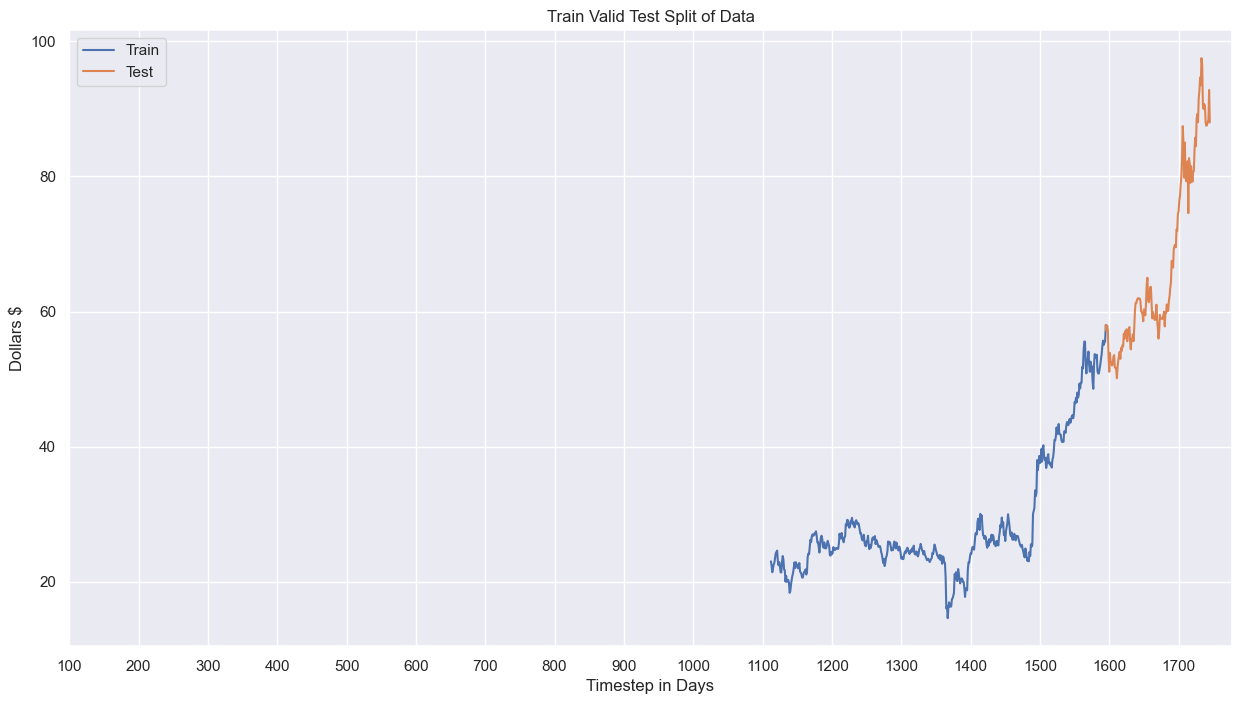

In [902]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 8]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
#plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,1300, 1400, 1500, 1600, 1700])
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
plt.savefig("test.png")

In [903]:
data = ["Carbon Price"]

for value in data:
    result = adfuller(df[[value]])
    print(f'{value} ADF Statistic: {result[0]}')
    print(f'{value} p-value: {result[1]}')  #If p-value < 0.05, data is stationary.

Carbon Price ADF Statistic: 2.0525813825821153
Carbon Price p-value: 0.9987374990823455


In [904]:
# Get the difference of each Adj Close point
carbon_diff = series.diff()
carbon_diff.dropna(inplace=True)
df["diff"] = carbon_diff

In [905]:


# Create train data set
train_split_date = '2021-07-01'
#train_split_index = np.where(df.Date == train_split_date)
x_train = df.loc[df['Date'] <= train_split_date]['diff']

# Create test data set
test_split_date = '2021-07-01'
#test_split_index = np.where(df.Date == test_split_date)
x_test = df.loc[df['Date'] >= test_split_date]['diff']

# Create valid data set
#valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = df.loc[(df['Date'] < test_split_date) & (df['Date'] > train_split_date)]['diff']

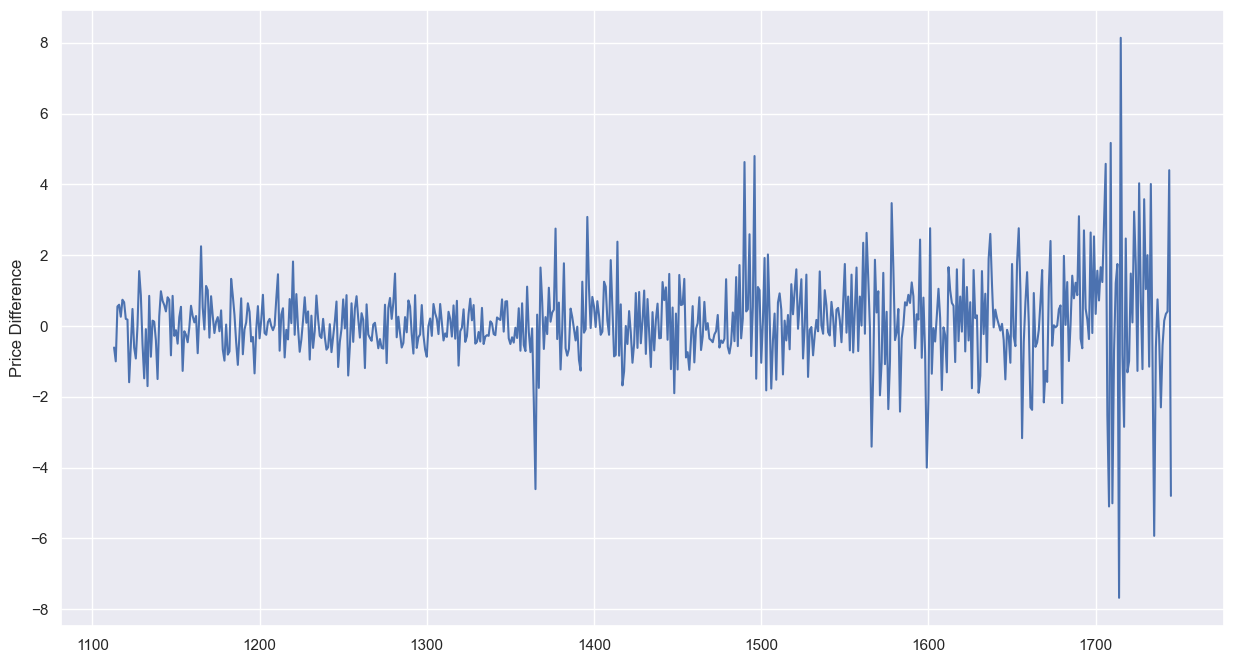

In [906]:
plt.plot(carbon_diff)
plt.ylabel("Price Difference")
plt.savefig("Carbondiff.png")

In [907]:
result = adfuller(carbon_diff)
print(f'{value} ADF Statistic: {result[0]}')
print(f'{value} p-value: {result[1]}') 

Carbon Price ADF Statistic: -5.9136117993707025
Carbon Price p-value: 2.6038299947485067e-07


C:\Users\rafir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


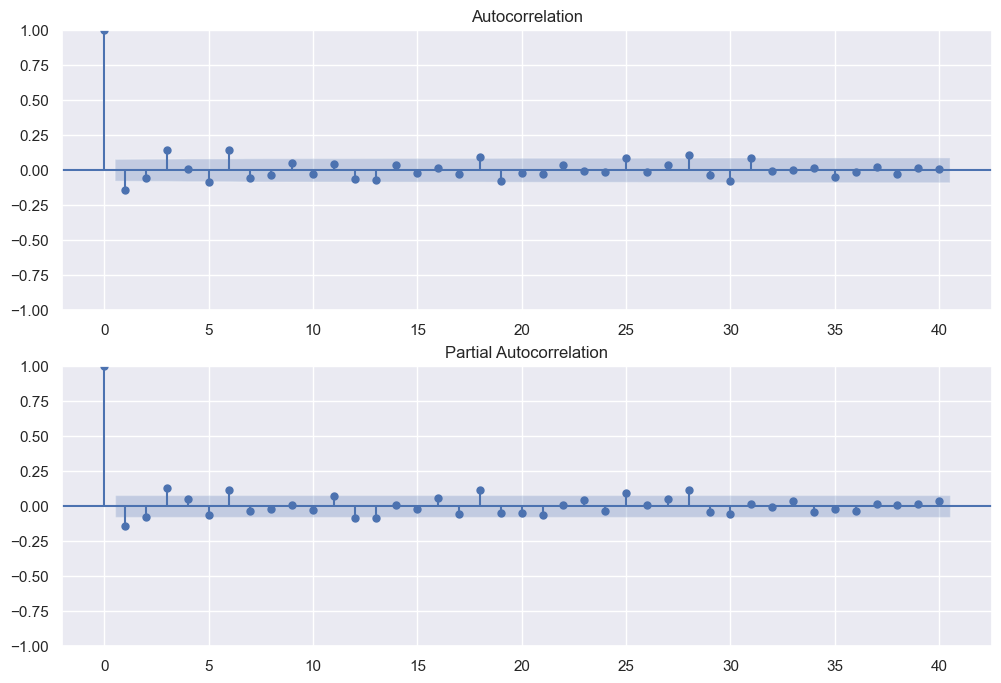

In [908]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
# plot_acf(carbon_diff)
# plt.xlabel('Lags (Days)')
# plt.show()

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(carbon_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(carbon_diff, lags=40, ax=ax2)
fig.savefig("acf.png")

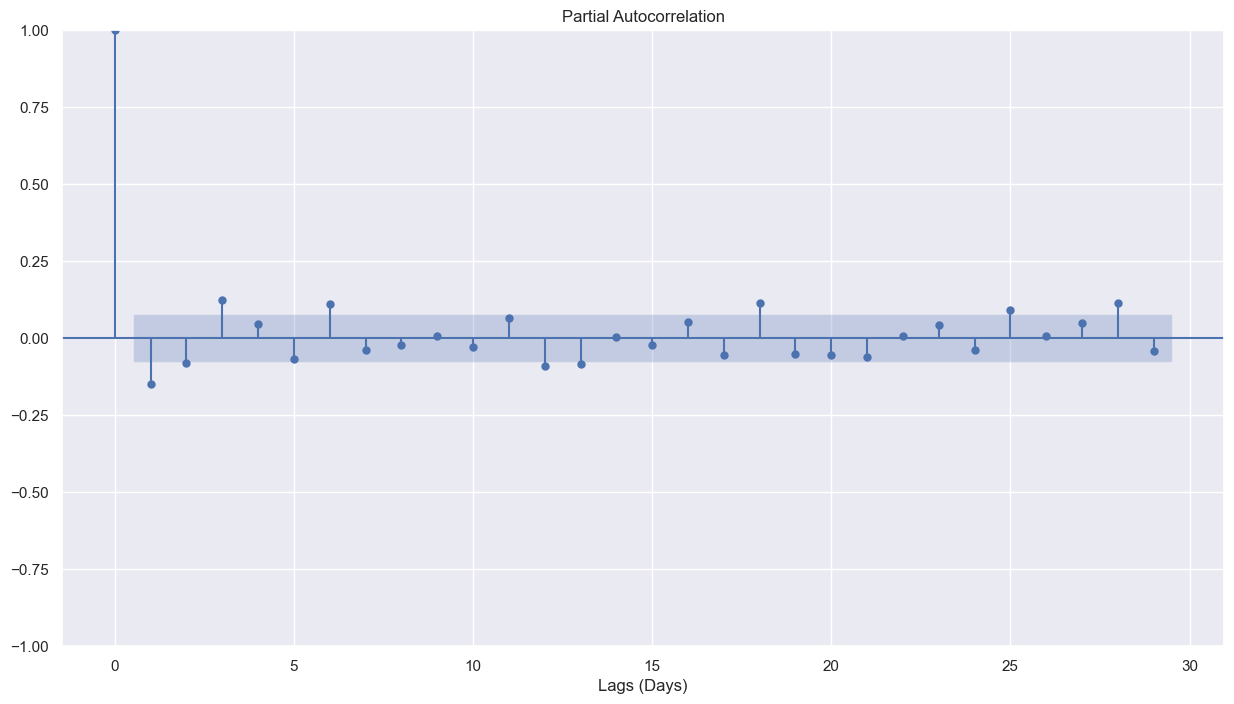

In [909]:
plot_pacf(carbon_diff)
plt.xlabel('Lags (Days)')
plt.show()


In [910]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
carbon_arima = ARIMA(x_train, order=(1,1,0))
carbon_arima_fit = carbon_arima.fit()
print(carbon_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                  484
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -753.716
Date:                Tue, 28 Feb 2023   AIC                           1511.432
Time:                        13:46:36   BIC                           1519.792
Sample:                             0   HQIC                          1514.718
                                - 484                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5140      0.033    -15.443      0.000      -0.579      -0.449
sigma2         1.2923      0.054     23.821      0.000       1.186       1.399
Ljung-Box (L1) (Q):                  21.29   Jarque-

C:\Users\rafir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rafir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rafir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\rafir\AppData\Local\Temp\ipykernel_19656\49514475.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats


NormaltestResult(statistic=nan, pvalue=nan)


C:\Users\rafir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


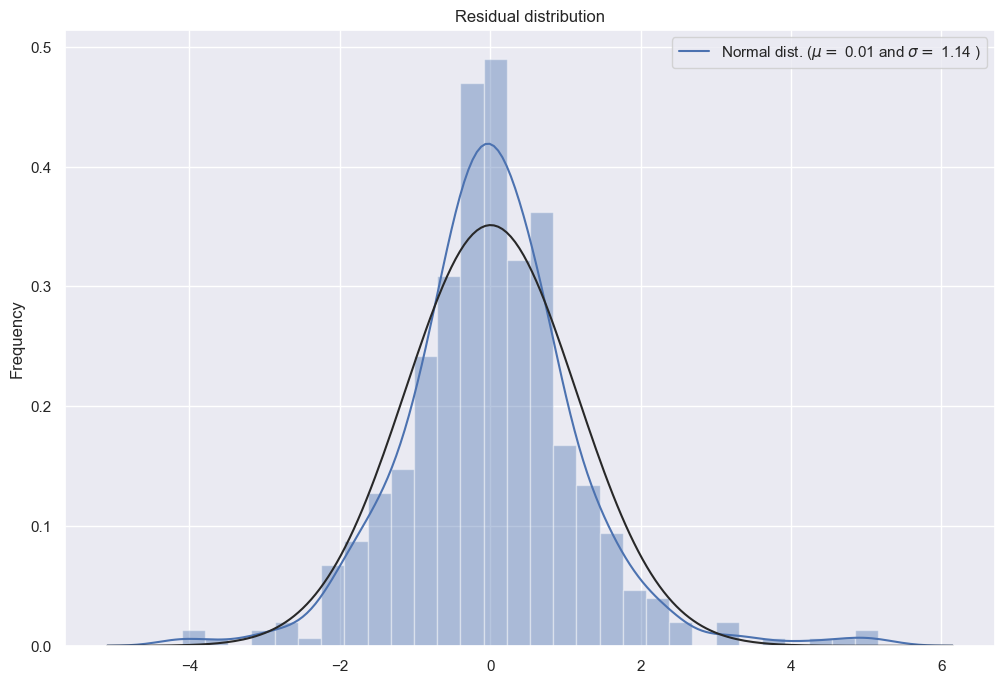

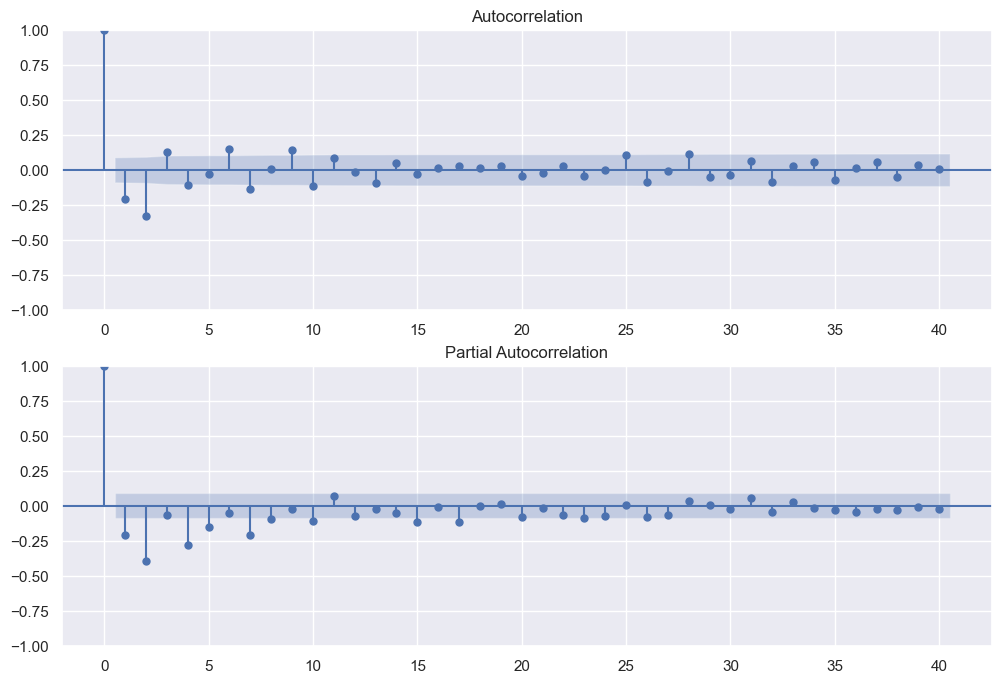

In [911]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = carbon_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)


residuals.dropna(inplace = True)
sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

In [912]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(4,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
        


%store model_predictions

Stored 'model_predictions' (list)


In [913]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  634
Model:                 ARIMA(4, 2, 0)   Log Likelihood               -1232.014
Date:                Tue, 28 Feb 2023   AIC                           2474.029
Time:                        13:46:45   BIC                           2496.273
Sample:                             0   HQIC                          2482.668
                                - 634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4620      0.024    -59.796      0.000      -1.510      -1.414
ar.L2         -1.3917      0.041    -33.715      0.000      -1.473      -1.311
ar.L3         -0.8253      0.046    -18.013      0.0

NormaltestResult(statistic=array([86.1733675]), pvalue=array([1.93950545e-19]))
This distribution is not a normal distribution


C:\Users\rafir\AppData\Local\Temp\ipykernel_19656\2105859516.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats
C:\Users\rafir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


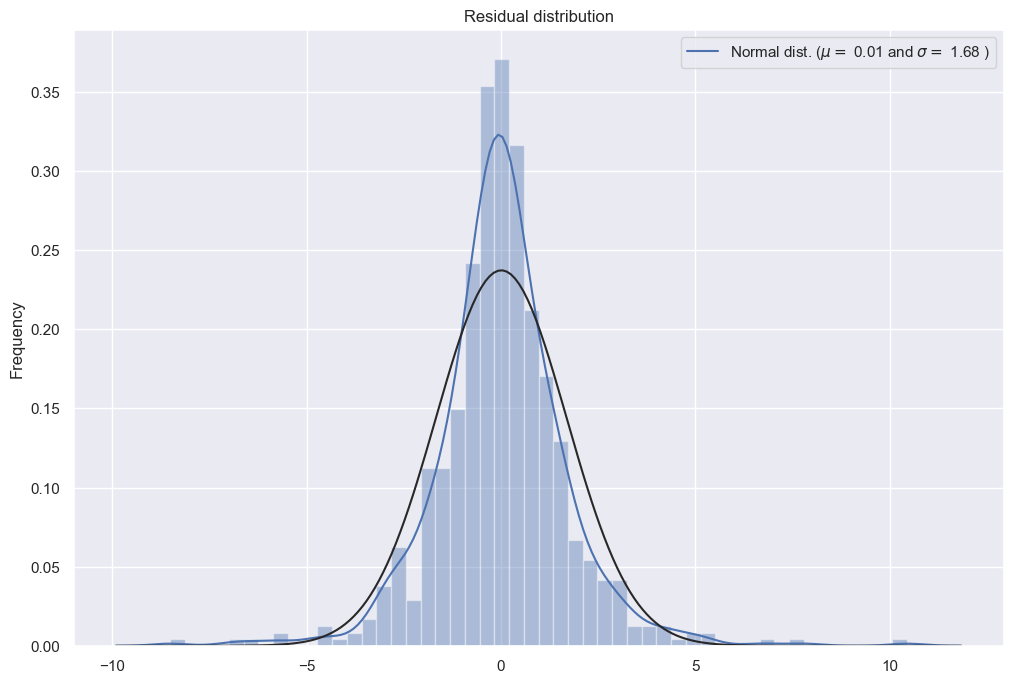

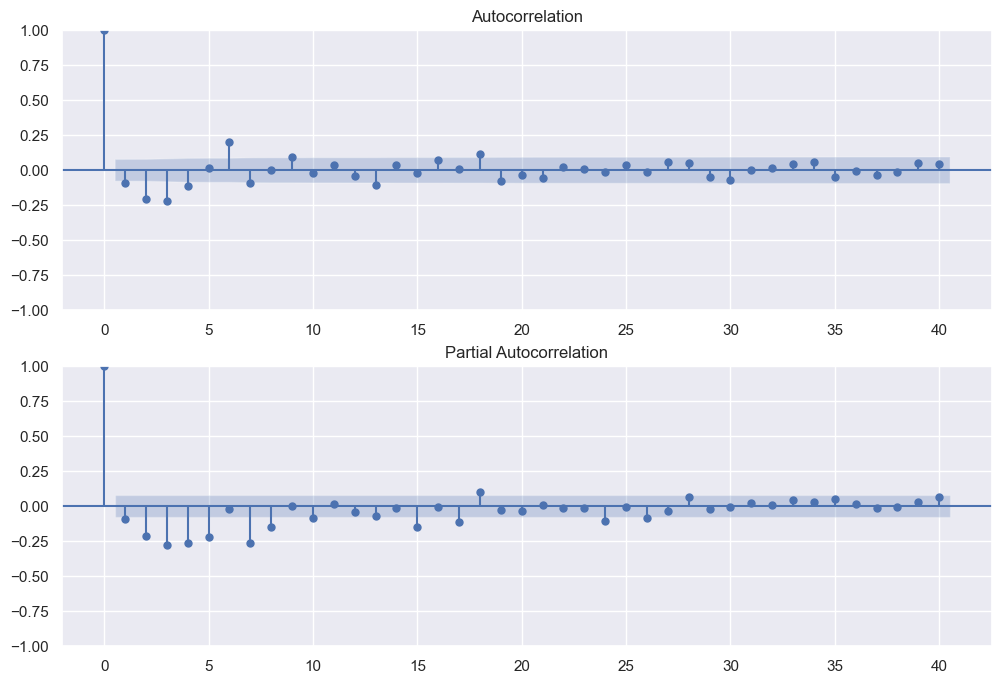

In [914]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = pd.DataFrame(model_fit.resid)
residuals.dropna(inplace = True)
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)



sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
plt.savefig("Arimares.png")


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

In [915]:
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

Testing Mean Squared Error is 1.987946071114668


In [916]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[1.3484998349266144,
 2.7319590550541126,
 1.667902507847641,
 0.7491169430866513,
 -1.1532582029560396]

In [917]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()

# Save to our dictionary of model mae scores
#model_mae_scores['ARIMA'] = arima_mae
#model_mae_scores

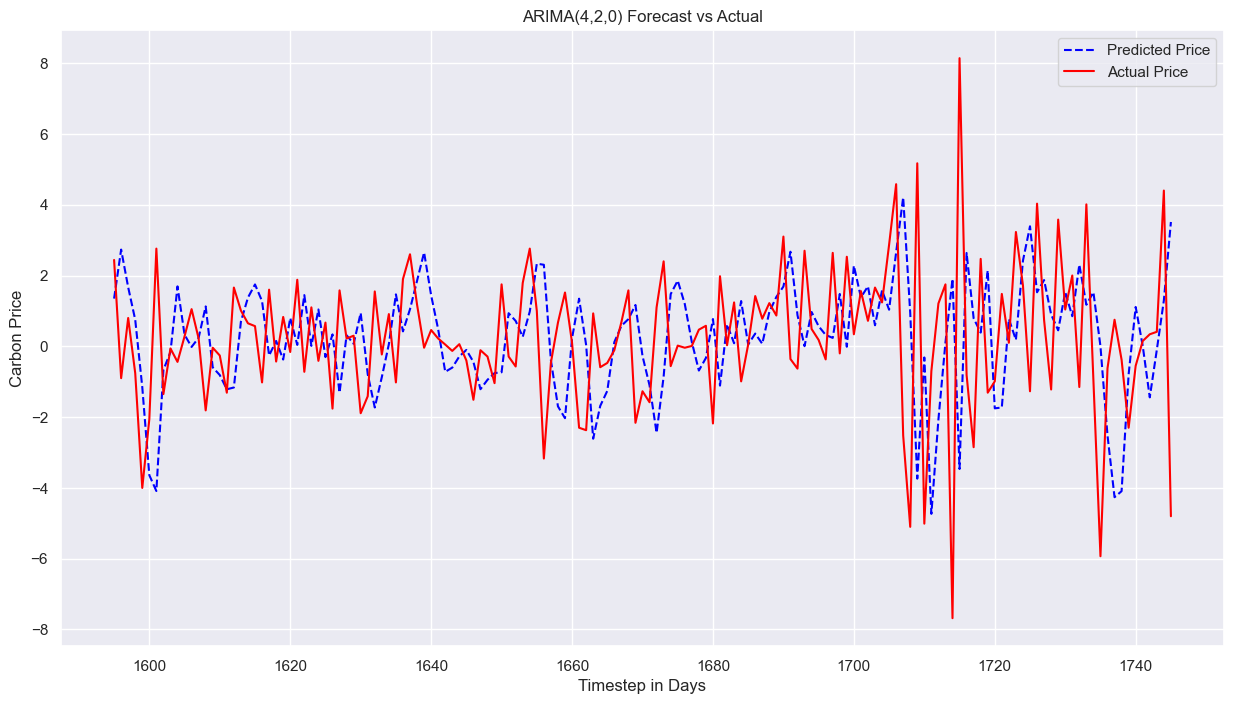

<Figure size 1000x600 with 0 Axes>

In [918]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index, model_predictions, color='blue',label='Predicted Price', linestyle = '--')
plt.plot(x_test.index, x_test, color='red', label='Actual Price')
plt.ylabel('Carbon Price')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(4,2,0) Forecast vs Actual')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.savefig("ARIMA.png")
plt.figure(figsize=(10,6))

plt.show()


In [919]:
x_test1

1595    58.01
1596    57.11
1597    57.91
1598    57.15
1599    53.15
        ...  
1741    87.65
1742    87.99
1743    88.40
1744    92.80
1745    88.00
Name: Carbon Price, Length: 151, dtype: float64

In [920]:
x_test1 = x_test1.drop(index = 1745)

In [921]:
x_test1

1595    58.01
1596    57.11
1597    57.91
1598    57.15
1599    53.15
        ...  
1740    87.50
1741    87.65
1742    87.99
1743    88.40
1744    92.80
Name: Carbon Price, Length: 150, dtype: float64

In [922]:
df2 = pd.DataFrame(model_predictions, columns = ["diff"])
df2.loc[-1] = [24.06]  # adding a row
df2.index = df2.index + 1  # shifting index
df2.sort_index(inplace=True) 

df2["Pred"] = df2['diff'].cumsum()
df2.drop(df2.tail(2).index,inplace=True)
df2["Actual"] = x_test1.to_numpy()

df2.head()

,diff,Pred,Actual
0,24.060000,24.060000,58.01
1,1.348500,25.408500,57.11
2,2.731959,28.140459,57.91
3,1.667903,29.808361,57.15
4,0.749117,30.557478,53.15


In [927]:
df2["Pred"] = df2["Pred"] +32

In [928]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
# Evaluate the performance of the model
print('mean_squared_error : ', mean_squared_error(df2["Actual"], df2["Pred"]))
print('mean_absolute_error : ', mean_absolute_error(df2["Actual"], df2["Pred"]))
print("root_mean_squared_error: ", np.sqrt(mean_squared_error(df2["Actual"],df2["Pred"])))
print("R^2: " ,r2_score(df2["Actual"], df2["Pred"]))


mean_squared_error :  12.408351100983682
mean_absolute_error :  2.725154309454773
root_mean_squared_error:  3.522548949409175
R^2:  0.9267864700247127


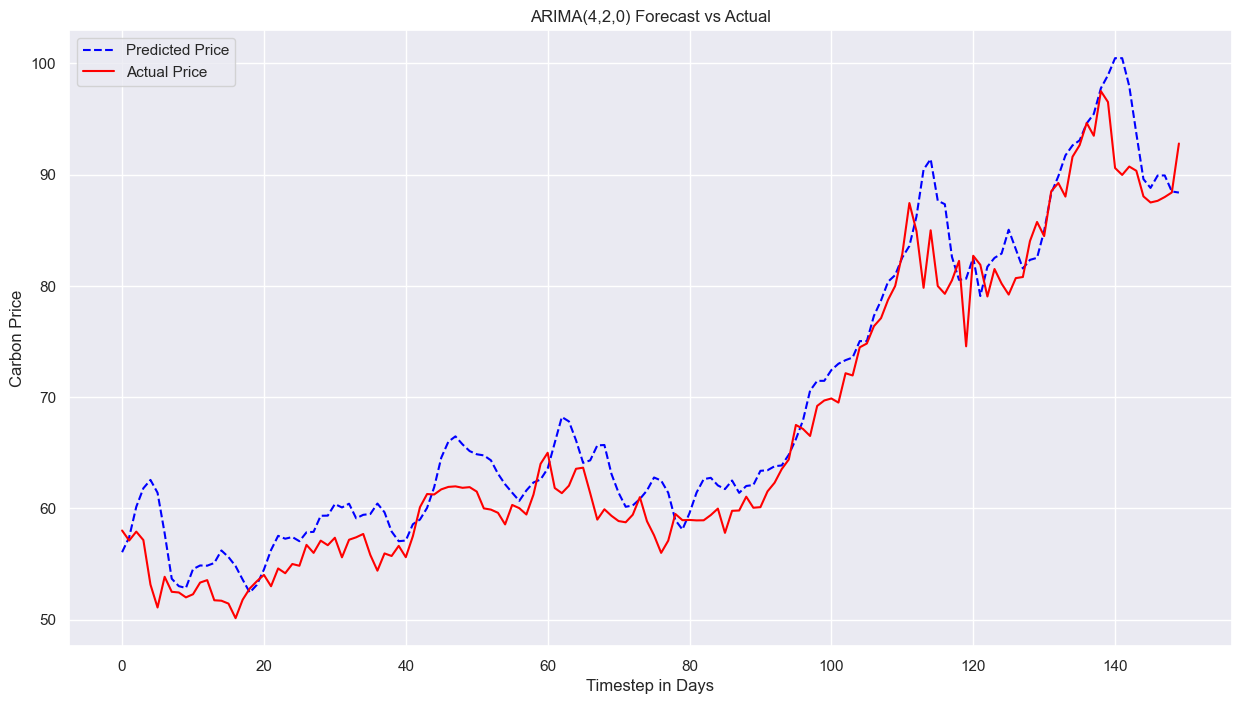

<Figure size 1000x600 with 0 Axes>

In [929]:
plt.plot(df2["Pred"], color='blue',label='Predicted Price', linestyle = '--')
plt.plot(df2["Actual"], color='red',label='Actual Price', linestyle = '-')
plt.ylabel('Carbon Price')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(4,2,0) Forecast vs Actual')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.savefig("Arimaprice.png")
plt.figure(figsize=(10,6))
plt.show()

In [930]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

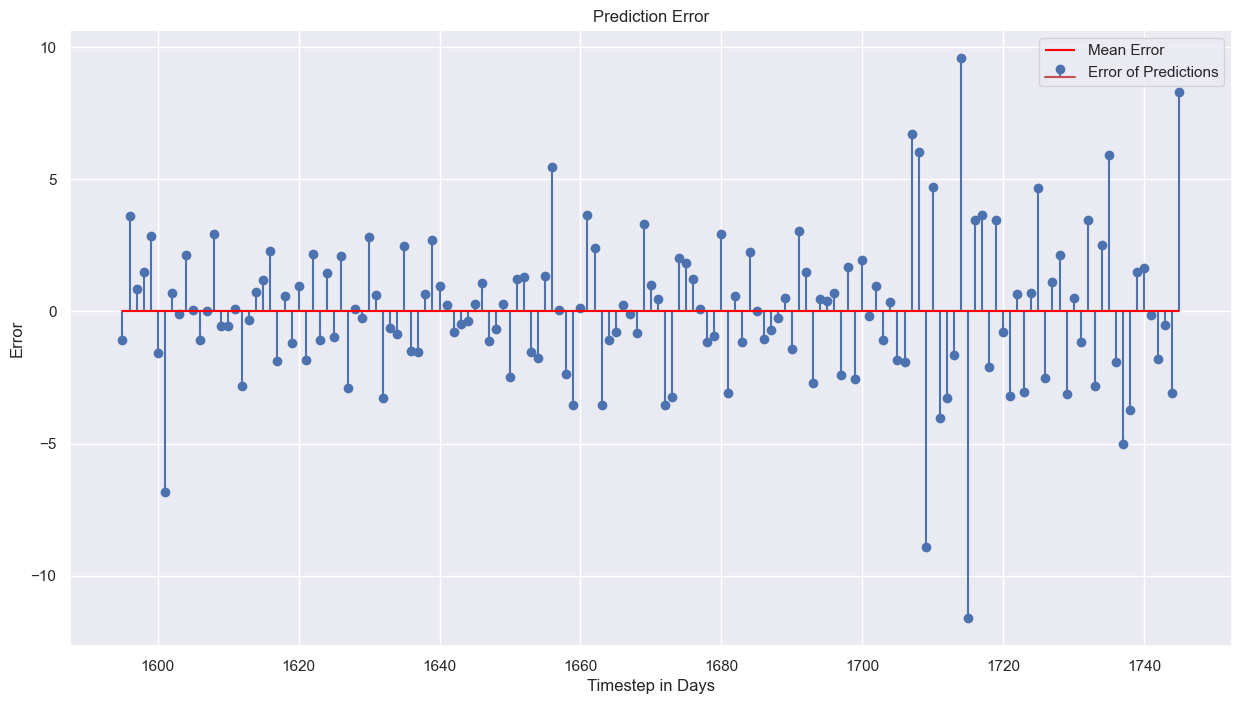

<Figure size 1000x600 with 0 Axes>

In [931]:
plt.stem(x_test.index, arima_error, label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.savefig("ARIMAerror.png")
plt.figure(figsize=(10,6))
plt.show()